### Lane Detection

#### Load Data

In [1]:
# LOAD DATA
# Import Modules
import pickle
import os
import pickle
import math
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
import random
from sklearn.utils import shuffle
import csv
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
%matplotlib inline

print('Import Modules')

Import Modules


In [2]:
# LOAD DATA
# Load Image Directory
os.chdir('..')
OS=str(os.getcwd())

# Load Sample Image
Image=mpimg.imread('Test-Images/solidYellowCurve.jpg')

# Convert to Grayscale
Gray=cv2.cvtColor(Image,cv2.COLOR_RGB2GRAY)

# Print Image Information
print('This image is:',type(Image),'with dimesions:',Image.shape)
print('This image is:',type(Gray),'with dimesions:',Gray.shape)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


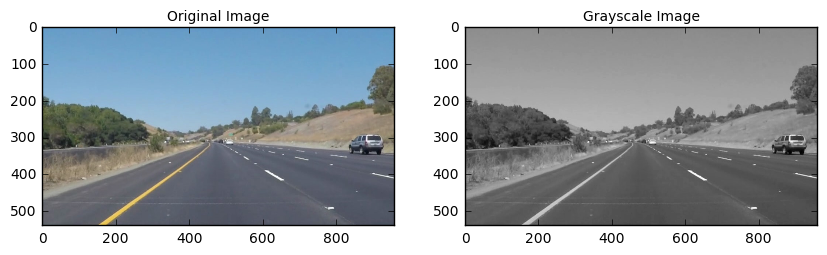

In [3]:
# LOAD DATA
# Plot Images
Fig,(Axis1,Axis2)=plt.subplots(1,2,figsize=(10,10))
Axis1.imshow(Image)
Axis2.imshow(Gray,cmap='gray')
Axis1.set_title('Original Image',fontsize=10)
Axis2.set_title('Grayscale Image',fontsize=10)

#### Edge Detection

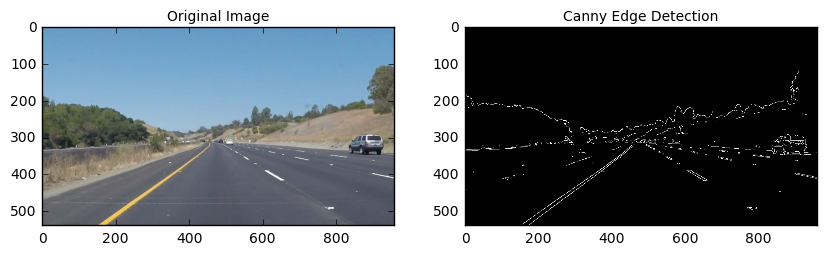

In [4]:
# EDGE DETECTION
# Set Parameters for Canny Edge Detection
LowThreshold=150 
HighThreshold=200

# Implement Canny on Sample Image Detection
Edges=cv2.Canny(Gray,LowThreshold,HighThreshold)

# Plot 
Fig,(Axis1,Axis2)=plt.subplots(1,2,figsize=(10,10))
Axis1.imshow(Image)
Axis2.imshow(Edges,cmap='gray')
Axis1.set_title('Original Image',fontsize=10)
Axis2.set_title('Canny Edge Detection',fontsize=10)

In [5]:
# EDGE DETECTION
# Define a Function for ROI
def ROI(Img,Vertices):
    # Define a Blanck Mask 
    Mask=np.zeros_like(Img)   
    
    # Define a 3-Channel or 1-Channel Color to Fill the Mask
    if len(Img.shape)>2:
        ChannelCount=Img.shape[2]
        IgnoreMaskColor=(255,)*ChannelCount
    else:
        IgnoreMaskColor=255

    # Fill Pixels inside the Polygon 
    cv2.fillPoly(Mask,Vertices,IgnoreMaskColor)
    
    # Return
    MaskedImage=cv2.bitwise_and(Img,Mask)
    return MaskedImage

print('ROI is Defined!')

ROI is Defined!


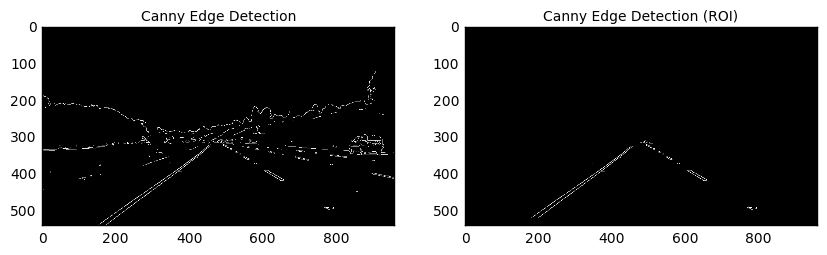

In [6]:
# EDGE DETECTION
# Mask Region of Interest
Imshape=Image.shape
Vertices=np.array([[(0,Imshape[0]-20),(490,310),(490,310),(Imshape[1],Imshape[0]-20)]],dtype=np.int32)
Mask=ROI(Edges,Vertices) 

# Plot
Fig,(Axis1,Axis2)=plt.subplots(1,2,figsize=(10,10))
Axis1.imshow(Edges,cmap='gray')
Axis2.imshow(Mask,cmap='gray')
Axis1.set_title('Canny Edge Detection',fontsize=10)
Axis2.set_title('Canny Edge Detection (ROI)',fontsize=10)

In [7]:
# EDGE DETECTION
# Define a Function to Draw Lines
def DrawLines(Img,Imshape,Lines,Color,Thickness=2):
    # Initialize Arrays
    SlopeLeftGrad=[]
    SlopeLeftIntercept=[]
    SlopeRightGrad=[]
    SlopeRightIntercept=[]
    
    # Check Each Line 
    for Line in Lines:
        for X1,Y1,X2,Y2 in Line:
            X=[X1,X2]
            Y=[Y1,Y2]
            
            # Check Equation of Each Line
            Coefficients=np.polyfit(X,Y,1)
            
            # Check if Lane is Left or Right Lane
            if (Coefficients[0]>0):
                SlopeLeftGrad.append(Coefficients[0])
                SlopeLeftIntercept.append(Coefficients[1])
            else: 
                SlopeRightGrad.append(Coefficients[0])
                SlopeRightIntercept.append(Coefficients[1])
    
    # Compute Median of All Left & Right Lanes
    LaneLeftGrad=float(np.median(SlopeLeftGrad))
    LaneLeftIntercept=int(np.median(SlopeLeftIntercept))
    LaneRightGrad=float(np.median(SlopeRightGrad))
    LaneRightIntercept=int(np.median(SlopeRightIntercept))
    
    # Plot Lines
    cv2.line(Img,(int((Imshape[0]-LaneRightIntercept)/LaneRightGrad),Imshape[0]),
             (int((320-LaneRightIntercept)/LaneRightGrad),320),
             Color,Thickness)
    cv2.line(Img,(int((Imshape[0]-LaneLeftIntercept)/LaneLeftGrad),Imshape[0]),
             (int((320-LaneLeftIntercept)/LaneLeftGrad),320),
             Color,Thickness)
    
print('DrawLines is Defined!')

DrawLines is Defined!


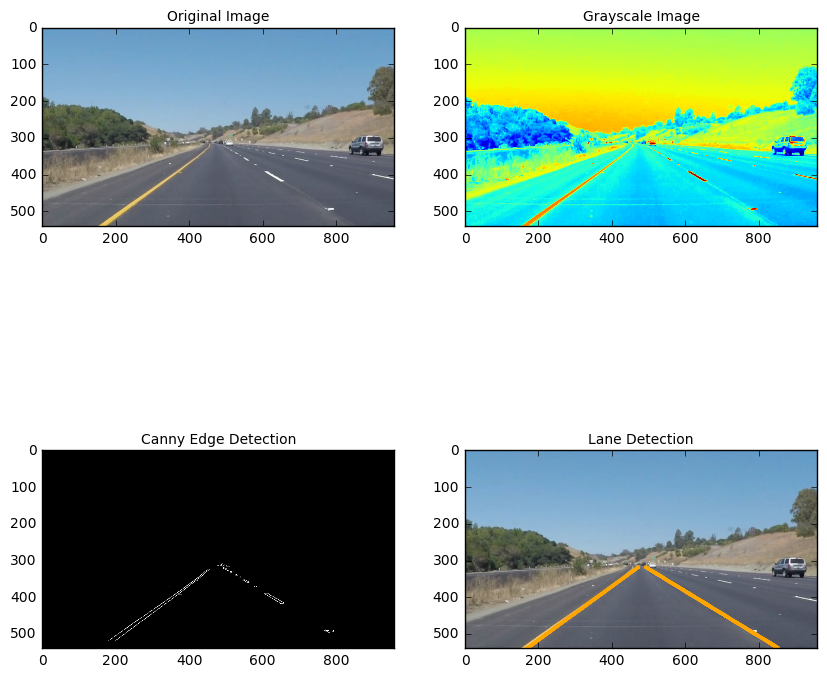

In [21]:
# EDGE DETECTION
# Set Parameters for Hough Transform
Rho=2 
Theta=1*np.pi/180 
Threshold=15    
MinLineLength=100 
MaxLineGap=150 

# Implement Hough Transform via OpenCV
Lines=cv2.HoughLinesP(Mask,Rho,Theta,Threshold,np.array([]),minLineLength=MinLineLength,maxLineGap=MaxLineGap)

# Copy Original Image
LaneImg=Image.copy()

# Draw Lines
DrawLines(LaneImg,Imshape,Lines,Color=[255,165,0],Thickness=10)

# Plot Lanes
Fig,((Axis1,Axis2),(Axis3,Axis4))=plt.subplots(2,2,figsize=(10,10))
Axis1.imshow(Image)
Axis2.imshow(Gray)
Axis3.imshow(Mask,cmap='gray')
Axis4.imshow(LaneImg)
Axis1.set_title('Original Image',fontsize=10)
Axis2.set_title('Grayscale Image',fontsize=10)
Axis3.set_title('Canny Edge Detection',fontsize=10)
Axis4.set_title('Lane Detection',fontsize=10)

#### Lane Detection on Video

In [14]:
# LANE DETECTION 
# Define a Function to Process Each Image
def ProcessImage(Image):
    # Convert to Grayscale
    Gray=cv2.cvtColor(Image,cv2.COLOR_RGB2GRAY)

    # Define a Kernel Size and Apply Gaussian Smoothing
    KernelSize=5
    BlurGray=cv2.GaussianBlur(Image,(KernelSize,KernelSize),0)
    
    # Set Parameters for Canny Edge Detection
    LowThreshold=150 
    HighThreshold=200

    # Implement Canny on Sample Image Detection
    Edges=cv2.Canny(BlurGray,LowThreshold,HighThreshold)
    
    # Mask Region of Interest
    Imshape=Image.shape
    Vertices=np.array([[(0,Imshape[0]-20),(490,310),(490,310),(Imshape[1],Imshape[0]-20)]],dtype=np.int32)
    Mask=ROI(Edges,Vertices) 
    
    # Set Parameters for Hough Transform
    Rho=2 
    Theta=1*np.pi/180 
    Threshold=15    
    MinLineLength=100 
    MaxLineGap=150 

    # Implement Hough Transform via OpenCV
    Lines=cv2.HoughLinesP(Mask,Rho,Theta,Threshold,np.array([]),minLineLength=MinLineLength,maxLineGap=MaxLineGap)

    # Draw Lines
    DrawLines(Image,Imshape,Lines,Color=[255,165,0],Thickness=10)
    
    return Image

In [15]:
# LANE DETECTION 
# Lane Detection on Video
Output='Videos/OutputWhite.mp4'
Clip01=VideoFileClip("Videos/solidWhiteRight.mp4")
WhiteClip=Clip01.fl_image(ProcessImage)
%time WhiteClip.write_videofile(Output,audio=False)

[MoviePy] >>>> Building video Videos/OutputWhite.mp4
[MoviePy] Writing video Videos/OutputWhite.mp4


100%|█████████▉| 221/222 [00:05<00:00, 36.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Videos/OutputWhite.mp4 

CPU times: user 33.2 s, sys: 168 ms, total: 33.3 s
Wall time: 6.38 s


In [16]:
# LANE DETECTION 
# Lane Detection on Video
Output='Videos/OutputYellow.mp4'
Clip01=VideoFileClip("Videos/solidYellowLeft.mp4")
YellowClip=Clip01.fl_image(ProcessImage)
%time YellowClip.write_videofile(Output,audio=False)

[MoviePy] >>>> Building video Videos/OutputYellow.mp4
[MoviePy] Writing video Videos/OutputYellow.mp4


100%|█████████▉| 681/682 [00:18<00:00, 35.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Videos/OutputYellow.mp4 

CPU times: user 1min 44s, sys: 508 ms, total: 1min 44s
Wall time: 19.3 s
